# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

# Import modules

In [6]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline


# API for students

In [8]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [10]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

In [12]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


Pretty *unhelpful* !

What are these mysteriously named features ?

## Description of attributes

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [21]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

print("Data shape: ", holdout_data.shape)


Data shape:  (1092, 65)


We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.

So choose one (explain why !) and obey the following guidelines.

The objective of creating the guideline is to simplify the evaluation of your model.

We have specified this by requiring you to implement a function called `MyModel`
- which takes an unlabeled holdout dataset (one example per row)
- and returns an array of predictions (one per holdout example)

We will evaluate your model by passing a holdout dataset into your implemention of `MyModel`

- obtaining predictions
- evaluating the predictions against metrics such as Accuracy and Recall











To be specific:

You will implement the body of a subroutine `MyModel`

The subroutine
- takes as argument a Pandas DataFrame 
    - Each row is an example on which to predict
    - The features of the example are elements of the row
- Performs predictions on each example
- Returns an array of predictions with a one-to-one correspondence with the examples in the test set

Here is what `MyModel` should look like:


    def MyModel(data, other={}):
        """
        Parameters
        -----------
        data: a Pandas DataFrame
        other: a dict
            You can use this to pass any other arguments you find are necessary
            
        Returns
        -------
        pred: an array of predicted values
            The number of elements (i.e., predictions) is equal to the number of examples in the 'data' parameter
                i.e., one prediction per example
        """
        
        # The function should create an array of predictions; we initialize it to the empty array for convenience
        pred = []
   
        # YOUR CODE HERE
        
        return pred

Your code should follow the comment `# YOUR CODE HERE`

We will evaluate your model against the holdout data
- By reading the holdout examples `X_hold` (as above)
- Calling `y_hold_pred = MyModel(X_hold, other)` to get the predictions
- Comparing the predicted values `y_hold_pred` against the true labels `y_hold` which are known only to the instructors

See the following cell as an illustration

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

**2. Explore the Data**

2.1.1 Missing values and convert columns to numeric:
Look through the data and check if there is missing data

In [32]:
# Convert all columns to numeric for correlation calculation
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Get summary statistics
data.describe(include='all')

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
count,4816.000000,4816.000000,4816.000000,4803.000000,4.808000e+03,4816.000000,4816.000000,4804.000000,4818.000000,4816.000000,...,4816.000000,4818.000000,4816.000000,4.598000e+03,4806.000000,4818.000000,4803.000000,4735.000000,4818.000000,4818.000000
mean,-0.055232,0.533272,0.188992,4.978602,1.956441e+01,-0.070060,-0.042516,5.739985,1.579277,0.503606,...,0.022793,0.959585,0.273025,1.108795e+03,11.021303,177.494445,9.287631,38.557533,0.063927,3499.858032
std,6.707351,1.202909,1.282430,100.273952,2.384491e+04,7.778523,6.707970,109.508001,1.342723,4.044036,...,7.249022,0.932427,6.338601,7.106563e+04,43.821146,2279.713700,113.225922,588.711967,0.244648,1392.049260
min,-463.890000,0.000000,-72.067000,0.000000,-1.076400e+06,-463.890000,-463.890000,-3.735100,0.000191,-71.444000,...,-468.670000,-0.085920,-184.980000,-1.244000e+01,-0.092493,0.000000,0.000000,-3.726500,0.000000,1071.000000
25%,0.004047,0.254670,0.044923,1.099200,-4.312000e+01,0.000000,0.005985,0.481588,1.015600,0.318990,...,0.015574,0.876940,0.000000,5.298300e+00,4.229925,45.065750,3.074350,2.114850,0.000000,2296.250000
50%,0.046487,0.451495,0.218560,1.642300,3.673450e-01,0.000000,0.056685,1.149000,1.140500,0.522325,...,0.108940,0.950825,0.006320,9.038900e+00,6.176800,73.879500,4.928700,4.077200,0.000000,3500.500000
75%,0.116730,0.662177,0.420152,2.929200,4.986775e+01,0.110470,0.136025,2.781300,1.814050,0.721823,...,0.240262,0.990358,0.206915,1.720750e+01,9.302800,118.597500,8.067850,9.187600,0.000000,4704.750000
max,2.352300,72.416000,28.336000,6845.800000,1.250100e+06,203.150000,2.352300,6868.500000,37.807000,266.860000,...,87.981000,47.788000,308.150000,4.818700e+06,1308.500000,127450.000000,7641.300000,28999.000000,1.000000,5909.000000


In [33]:
# Check for missing values
missing_values = data.isnull().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Columns with missing values:
X1        2
X2        2
X3        2
X4       15
X5       10
X6        2
X7        2
X8       14
X10       2
X11       2
X12      15
X14       2
X15       6
X16      14
X17      14
X18       2
X21      74
X22       2
X24     116
X25       2
X26      14
X27     305
X28      83
X29       2
X32      42
X33      15
X34      14
X35       2
X36       2
X37    2068
X38       2
X40      15
X41      62
X45     220
X46      15
X47      31
X48       2
X50      14
X51       2
X52      32
X53      83
X54      83
X57       2
X59       2
X60     220
X61      12
X63      15
X64      83
dtype: int64


2.1.2 Calculate Percentage of Missing Values
Let's calculate the percentage of missing values for each column and identify columns to drop 

In [35]:
# Calculate percentage of missing values per column
missing_percent = (missing_values / data.shape[0]) * 100
print("Percentage of missing values per column:")
print(missing_percent[missing_percent > 0])

# Set threshold to 40%
threshold = 40  # percent

# Identify columns to drop
cols_to_drop = missing_percent[missing_percent > threshold].index
print("\nColumns to drop:")
print(cols_to_drop)

Percentage of missing values per column:
X1      0.041511
X2      0.041511
X3      0.041511
X4      0.311333
X5      0.207555
X6      0.041511
X7      0.041511
X8      0.290577
X10     0.041511
X11     0.041511
X12     0.311333
X14     0.041511
X15     0.124533
X16     0.290577
X17     0.290577
X18     0.041511
X21     1.535907
X22     0.041511
X24     2.407638
X25     0.041511
X26     0.290577
X27     6.330428
X28     1.722707
X29     0.041511
X32     0.871731
X33     0.311333
X34     0.290577
X35     0.041511
X36     0.041511
X37    42.922374
X38     0.041511
X40     0.311333
X41     1.286841
X45     4.566210
X46     0.311333
X47     0.643421
X48     0.041511
X50     0.290577
X51     0.041511
X52     0.664176
X53     1.722707
X54     1.722707
X57     0.041511
X59     0.041511
X60     4.566210
X61     0.249066
X63     0.311333
X64     1.722707
dtype: float64

Columns to drop:
Index(['X37'], dtype='object')


2.1.3 Drop Columns Exceeding the Threshold

In [37]:
# Drop columns with more than 40% missing values
data = data.drop(columns=cols_to_drop)
print(f"Data shape after dropping columns: {data.shape}")


Data shape after dropping columns: (4818, 65)


2.1.4 for Missing values, I decided to go with both median and KNN imputation and later with 3 models --> total 6 models to compare which imputation is better

In [39]:
# Create a copy for median imputation
data_median = data.copy()

# Impute missing values with median
data_median = data_median.fillna(data_median.median())

# Verify no missing values remain
print("Total missing values after median imputation:", data_median.isnull().sum().sum())


Total missing values after median imputation: 0


In [40]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Create a copy for KNN imputation
data_knn = data.copy()

# Separate features and target
X_knn = data_knn.drop(['Bankrupt', 'Id'], axis=1)
y_knn = data_knn['Bankrupt']

# Scale features
scaler_knn = StandardScaler()
X_knn_scaled = scaler_knn.fit_transform(X_knn)

# Apply KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)
X_knn_imputed = knn_imputer.fit_transform(X_knn_scaled)

# Convert back to DataFrame
X_knn_imputed = pd.DataFrame(X_knn_imputed, columns=X_knn.columns)

# Add target and Id back
data_knn_imputed = pd.concat([X_knn_imputed, data_knn[['Bankrupt', 'Id']].reset_index(drop=True)], axis=1)

# Verify no missing values remain
print("Total missing values after KNN imputation:", data_knn_imputed.isnull().sum().sum())


Total missing values after KNN imputation: 0


End of Step 2 (Step 1 has already presented by predetermined project content)

Conclusion:
In this step, I performed a comprehensive exploration of the dataset to understand its structure and address the issue of missing values. Initially, I converted all columns to numeric data types to ensure accurate calculations and facilitate further statistical analysis. The summary statistics provided insights into the distribution, central tendency, and dispersion of the variables, revealing that some features contained missing values.

I identified the columns with missing data and calculated the percentage of missing values for each. Only one feature, 'X37', exceeded predefined threshold of 40% missing data, accounting for approximately 42.92% missing values. While I considered dropping this column due to its high proportion of missing data, we decided to retain all features for the initial analysis to preserve as much information as possible.

To handle the missing values effectively, I opted to employ two imputation methods: median imputation and K-Nearest Neighbors (KNN) imputation. This dual approach allows us to compare the impact of different imputation techniques on model performance in subsequent steps. For median imputation, we filled the missing values with the median of each feature, which is robust to outliers and maintains the central tendency of the data. For KNN imputation, I first scaled the features and then imputed missing values based on the mean value of the nearest neighbors, capturing the underlying patterns in the data.

**3.Prepare Data**

3.1 Separate features and target:

I need to separate the input features (X) from the target variable (y) for both the median-imputed and KNN-imputed datasets.

In [43]:
# Separate features and target for median-imputed data
X_median = data_median.drop(['Bankrupt', 'Id'], axis=1)
y_median = data_median['Bankrupt']


In [44]:
# Separate features and target for KNN-imputed data
X_knn = data_knn_imputed.drop(['Bankrupt', 'Id'], axis=1)
y_knn = data_knn_imputed['Bankrupt']


3.2 Feature Scaling

Feature scaling is important, especially for algorithms that are sensitive to the scale of the data (e.g., logistic regression, KNN, SVM).

For the KNN imputed data, I have already scaled the features before imputation. However, since the imputation process might have altered the data slightly, it's advisable to scale the data again to ensure consistency.

In [46]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler for median-imputed data
scaler_median = StandardScaler()

# Fit and transform the features for median-imputed data
X_median_scaled = scaler_median.fit_transform(X_median)
X_median_scaled = pd.DataFrame(X_median_scaled, columns=X_median.columns)

# Initialize the scaler for KNN-imputed data
scaler_knn_post = StandardScaler()

# Fit and transform the features for KNN-imputed data
X_knn_scaled = scaler_knn_post.fit_transform(X_knn)
X_knn_scaled = pd.DataFrame(X_knn_scaled, columns=X_knn.columns)


In [261]:
# Assuming X_train and y_train are your training features and labels
scaler.fit(X_train)
final_model.fit(X_train, y_train)

StandardScaler()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Data Integrity: These preprocessing steps are vital for maintaining the integrity and quality of the data fed into our machine learning models.
Model Performance: Properly scaled and prepared data enhances the performance and reliability of the models, leading to more accurate and generalizable predictions.
Experimentation Consistency: By uniformly preparing both datasets, I set a consistent foundation for experimenting with different models and imputation techniques, facilitating a meaningful comparison of their impacts on model performance.

**4. Proceed to Split data**

split the data into training and validation sets.
splitting both the median-imputed and KNN-imputed datasets into training and validation sets.
The test_size=0.2 parameter means that 20% of the data will be used for validation, and 80% for training.
random_state=42 ensures reproducibility of the splits.

In [49]:
from sklearn.model_selection import train_test_split

# Split the median-imputed data
X_train_median, X_valid_median, y_train_median, y_valid_median = train_test_split(
    X_median_scaled, y_median, test_size=0.2, random_state=42
)


In [50]:
# Split the KNN-imputed data
X_train_knn, X_valid_knn, y_train_knn, y_valid_knn = train_test_split(
    X_knn_scaled, y_knn, test_size=0.2, random_state=42
)


4.2 Additional Consideration Since bankruptcy is a rare event, it's important to address class imbalance:

In [52]:
# For Median Imputed Data
print("Class distribution in Median Imputed Data:")
print(y_median.value_counts())
print("\nPercentage distribution:")
print(y_median.value_counts(normalize=True) * 100)

# For KNN Imputed Data
print("\nClass distribution in KNN Imputed Data:")
print(y_knn.value_counts())
print("\nPercentage distribution:")
print(y_knn.value_counts(normalize=True) * 100)


Class distribution in Median Imputed Data:
Bankrupt
0    4510
1     308
Name: count, dtype: int64

Percentage distribution:
Bankrupt
0    93.607306
1     6.392694
Name: proportion, dtype: float64

Class distribution in KNN Imputed Data:
Bankrupt
0    4510
1     308
Name: count, dtype: int64

Percentage distribution:
Bankrupt
0    93.607306
1     6.392694
Name: proportion, dtype: float64


Observation:

Both datasets exhibit significant class imbalance.
Approximately 94% of the companies are non-bankrupt (class 0).
Approximately 6% of the companies are bankrupt (class 1).
Implications:

The class imbalance can lead to models that are biased towards predicting the majority class.
Since missing a bankrupt company is five times worse, it's crucial to improve the model's ability to correctly identify bankrupt companies (i.e., increase recall for class 1).


4.2.2 Address Class Imbalance:

I'll implement SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes in the training data.Applying SMOTE only on the training data prevents data leakage into the validation set.
I'll also consider class weighting in our models.

SMOTE creates synthetic examples of the minority class (bankrupt companies) by interpolating between existing examples.
This helps the model learn patterns specific to the minority class without losing any data from the majority class.

In addition to SMOTE, I use class weighting in our models to further emphasize the importance of correctly predicting bankrupt companies.
I'll specify class_weight={0:1, 1:5} in our models to reflect the higher cost associated with missing a bankrupt company.


In [55]:
# Import SMOTE
from imblearn.over_sampling import SMOTE

In [56]:
# For Median Imputed Data:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_median_resampled, y_train_median_resampled = smote.fit_resample(X_train_median, y_train_median)

# Check the class distribution after resampling
print("After SMOTE - Median Imputed Data:")
print(y_train_median_resampled.value_counts())


After SMOTE - Median Imputed Data:
Bankrupt
0    3616
1    3616
Name: count, dtype: int64


Reset the indices of both X_knn_imputed and y_knn to ensure they align correctly.

In [58]:
#For KNN Imputed Data:

# Ensure X_knn_imputed and y_knn have reset indices
X_knn_imputed.reset_index(drop=True, inplace=True)
y_knn.reset_index(drop=True, inplace=True)

# Combine features and target
data_knn_imputed = pd.concat([X_knn_imputed, y_knn], axis=1)

# Verify that data_knn_imputed has no NaNs
print("Total NaNs in data_knn_imputed:", data_knn_imputed.isnull().sum().sum())

X_knn = data_knn_imputed.drop(['Bankrupt', 'Id'], axis=1, errors='ignore')
y_knn = data_knn_imputed['Bankrupt']

from sklearn.model_selection import train_test_split

X_train_knn, X_valid_knn, y_train_knn, y_valid_knn = train_test_split(
    X_knn, y_knn, test_size=0.2, random_state=42
)

print("Number of NaNs in X_train_knn:", np.isnan(X_train_knn).sum().sum())
print("Number of NaNs in X_valid_knn:", np.isnan(X_valid_knn).sum().sum())



Total NaNs in data_knn_imputed: 0
Number of NaNs in X_train_knn: 0
Number of NaNs in X_valid_knn: 0


In [59]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_knn_resampled, y_train_knn_resampled = smote.fit_resample(X_train_knn, y_train_knn)

# Check the class distribution after resampling
print("Class distribution after applying SMOTE:")
print(y_train_knn_resampled.value_counts())


Class distribution after applying SMOTE:
Bankrupt
0    3616
1    3616
Name: count, dtype: int64


Both datasets now have an equal number of samples for each class (0 and 1), confirming that SMOTE has effectively balanced the classes.

**5. Feature selections & Model for Logistic Regression**

5.1 Feature Selection for Logistic Regression
Method: Recursive Feature Elimination with Cross-Validation (RFECV)

Why RFECV?

RFECV helps in selecting the optimal number of features by recursively considering smaller and smaller sets of features.
It uses cross-validation to evaluate model performance for different numbers of features.
It is suitable for models that support feature coefficients, like logistic regression.

Also, I have tried to run without restrictions such as min_feature_to_select, resulting only choose X35 as the only one feature. To avoid an oversimplified model and possibly capture more complex patterns Therefore, I modify to add the restriction of min_features_to_select=5 to RFECV. 

From my observations of the dataset, imbalanced data (bankruptcy and nonbankruptcy) influenced my model. So I still want to address those problems 

5.1.1 for median method

In [63]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model with class weights
log_reg = LogisticRegression(max_iter=1000, class_weight={0:1, 1:5}, solver='liblinear', random_state=42)

# Initialize RFECV
rfecv = RFECV(estimator=log_reg, step=1, cv=5, scoring='recall', n_jobs=-1, min_features_to_select=5)


# Apply RFECV on the median-imputed, resampled data
rfecv.fit(X_train_median_resampled, y_train_median_resampled)

# Get selected features
selected_features_logreg = X_train_median_resampled.columns[rfecv.support_]
print("Selected features for Logistic Regression:")
print(selected_features_logreg)


RFECV(cv=5,
      estimator=LogisticRegression(class_weight={0: 1, 1: 5}, max_iter=1000,
                                   random_state=42, solver='liblinear'),
      min_features_to_select=5, n_jobs=-1, scoring='recall')

Selected features for Logistic Regression:
Index(['X1', 'X4', 'X8', 'X16', 'X17', 'X21', 'X25', 'X26', 'X35', 'X38',
       'X39', 'X40', 'X41', 'X46', 'X48', 'X49', 'X60'],
      dtype='object')


RFECV selected 17 features that contribute most to the model's performance in terms of recall.
These features are considered important for predicting bankruptcy according to the logistic regression model.

In [65]:
# Prepare validation data with selected features
X_valid_median_logreg = X_valid_median[selected_features_logreg]


In [66]:
# Train the logistic regression model on resampled data with selected features
log_reg.fit(X_train_median_resampled[selected_features_logreg], y_train_median_resampled)


LogisticRegression(class_weight={0: 1, 1: 5}, max_iter=1000, random_state=42,
                   solver='liblinear')

In [67]:
# Predict on validation set
y_pred_logreg_median = log_reg.predict(X_valid_median_logreg)

# Evaluate
from sklearn.metrics import accuracy_score, recall_score, precision_score

accuracy_logreg_median = accuracy_score(y_valid_median, y_pred_logreg_median)
recall_logreg_median = recall_score(y_valid_median, y_pred_logreg_median)
precision_logreg_median = precision_score(y_valid_median, y_pred_logreg_median)

print("\nLogistic Regression (Median Imputed Data):")
print(f"Accuracy: {accuracy_logreg_median:.2%}")
print(f"Recall: {recall_logreg_median:.2%}")
print(f"Precision: {precision_logreg_median:.2%}")



Logistic Regression (Median Imputed Data):
Accuracy: 31.33%
Recall: 94.29%
Precision: 9.12%


High Recall (94.29%): The model successfully identifies most of the actual bankrupt companies.
Low Precision (9.12%): A large number of companies predicted as bankrupt are actually not bankrupt.
Low Accuracy (31.33%): Overall, the model correctly predicts about 31% of the cases.
Possible Issue:

The model may be overcompensating for the minority class due to both SMOTE and class weighting, leading to many false positives.

5.1.2 for knn imputed data

In [70]:
# Resampled KNN-imputed training data
X_train_knn_resampled  # Features after SMOTE
y_train_knn_resampled  # Target after SMOTE

# Validation data
X_valid_knn  # KNN-imputed validation features
y_valid_knn  # Validation target


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
0,0.014909,-0.035045,-0.145867,-0.039545,-0.001279,0.026255,0.013937,-0.043472,-0.365100,-0.005529,...,-0.045374,0.034061,0.009686,-0.044432,0.071462,-0.015044,0.010902,-0.029754,-0.052639,-0.064566
1,0.009680,0.056792,0.018309,-0.023018,0.000971,0.013592,0.008154,-0.046754,-0.396308,-0.032210,...,0.435328,-0.014662,0.000436,-0.004950,0.157397,-0.015461,-0.141036,-0.058046,-0.010677,-0.062858
2,0.010471,0.165980,0.119144,-0.028289,-0.003956,0.009277,0.006874,-0.049093,-0.336275,-0.058491,...,0.012310,0.106146,0.004601,0.039980,0.154257,-0.015375,0.054014,-0.035382,-0.048744,-0.060165
3,0.060571,-0.227208,0.376674,-0.009155,0.002128,0.009008,0.071088,-0.026427,0.333404,0.058463,...,-0.090949,0.202839,0.062294,-0.179824,-0.043078,-0.015283,-0.162354,-0.060521,-0.000496,-0.033751
4,0.012719,0.039548,-0.143570,-0.039581,-0.001201,0.009008,0.012277,-0.045831,2.278162,-0.020884,...,-0.129465,-0.062144,0.006752,0.034135,-0.007689,-0.014977,0.131633,-0.061130,0.002469,-0.050063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7227,0.010931,0.212997,-0.179384,-0.040152,-0.003225,0.011332,0.009287,-0.049987,-0.425890,-0.072622,...,-0.134140,-0.064514,0.008737,0.035437,-0.038350,-0.015459,-0.006459,-0.036442,-0.045464,-0.043072
7228,-0.015896,0.230801,-0.382657,-0.044705,-0.009124,-0.025314,-0.020547,-0.050274,-0.610041,-0.077772,...,-0.161749,-0.138595,-0.127403,0.327534,0.077455,-0.015547,-0.063896,0.049229,-0.070806,-0.063664
7229,0.018738,-0.075686,0.091884,-0.031297,-0.000816,0.018064,0.019789,-0.039994,-0.419297,0.009286,...,0.276152,-0.053602,0.012924,0.026593,-0.038658,-0.015033,-0.145039,-0.039561,-0.043058,-0.053764
7230,-0.013537,0.187779,-0.158974,-0.039870,-0.003659,-0.004076,-0.015431,-0.049511,0.559667,-0.064959,...,-0.130173,-0.160246,-0.088253,0.091531,-0.030381,-0.015527,-0.021030,-0.026926,-0.054230,-0.050716


0       0
1       0
2       0
3       0
4       0
       ..
7227    1
7228    1
7229    1
7230    1
7231    1
Name: Bankrupt, Length: 7232, dtype: int64

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64
4340,0.008410,0.115364,-0.036437,-0.037531,-0.002893,0.011171,0.006528,-0.048031,-0.425953,-0.044645,...,0.111600,-0.064599,-0.002644,0.035508,-0.037197,-0.015431,-0.159234,-0.016256,-0.059079,-0.050765
1221,0.029055,-0.234840,0.054190,-0.027191,0.000510,0.009008,0.033532,-0.025141,-0.024786,0.060734,...,-0.100151,0.090764,0.022568,-0.082369,-0.036038,-0.015445,-0.134919,-0.056488,-0.015879,-0.060594
2083,0.030243,-0.362001,0.219042,0.015131,0.001695,0.009466,0.033408,0.031767,-0.099120,0.098559,...,0.100205,0.089427,0.019429,-0.090263,-0.043078,-0.015526,-0.094670,-0.068400,0.067380,-0.059976
1044,0.013099,0.174992,-0.106714,-0.038102,-0.002905,0.023314,0.013015,-0.049393,-0.390871,-0.063546,...,-0.080305,-0.005861,0.015100,-0.012083,0.222087,-0.015512,0.503090,-0.051753,-0.027874,-0.059958
2555,0.011539,0.012868,0.274459,-0.021063,-0.000217,0.009008,0.009642,-0.044912,-0.720221,-0.012948,...,-0.076431,0.014398,0.003629,0.005443,0.045015,-0.015587,-0.192585,-0.002095,-0.063370,-0.059358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,0.012773,0.040022,-0.099865,-0.038622,-0.003380,0.010794,0.011913,-0.047323,-0.410237,-0.044266,...,-0.100864,-0.037615,0.009790,0.013648,-0.039410,-0.015531,-0.102363,-0.026030,-0.054752,-0.057256
1634,0.016230,-0.311886,0.171097,-0.013925,0.004626,0.048099,0.014333,-0.012812,-0.423644,0.045074,...,-0.025877,-0.060565,0.007641,0.032236,-0.043078,-0.015502,-0.156954,-0.048716,-0.033516,-0.062097
367,0.009359,-0.131305,-0.029714,-0.035672,-0.000670,0.069906,0.007651,-0.037223,0.485797,0.029937,...,-0.127111,-0.061294,-0.001480,0.039122,-0.043078,-0.015362,-0.106695,-0.050933,-0.029523,-0.057500
2201,0.028414,-0.232437,0.184472,-0.022953,-0.001352,0.102421,0.031318,-0.025814,-0.379773,0.058248,...,-0.088895,0.011661,0.022115,-0.026284,-0.043078,-0.015544,0.011359,-0.058388,-0.009424,-0.054456


4340    0
1221    0
2083    0
1044    0
2555    0
       ..
111     0
1634    0
367     0
2201    0
4075    0
Name: Bankrupt, Length: 964, dtype: int64

In [71]:
# Convert to DataFrame if necessary
X_train_knn_resampled = pd.DataFrame(
    X_train_knn_resampled, columns=X_train_knn.columns
)


In [72]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model with class weights
log_reg_knn = LogisticRegression(
    max_iter=1000, class_weight={0: 1, 1: 5}, solver='liblinear', random_state=42
)

# Initialize RFECV with 5-fold cross-validation
rfecv_knn = RFECV(
    estimator=log_reg_knn, step=1, cv=5, scoring='recall', n_jobs=-1, min_features_to_select=5
)

# Apply RFECV on the KNN-imputed, resampled data
rfecv_knn.fit(X_train_knn_resampled, y_train_knn_resampled)

# Get selected features
selected_features_logreg_knn = X_train_knn_resampled.columns[rfecv_knn.support_]
print("Selected features for Logistic Regression (KNN Imputed Data):")
print(selected_features_logreg_knn)


RFECV(cv=5,
      estimator=LogisticRegression(class_weight={0: 1, 1: 5}, max_iter=1000,
                                   random_state=42, solver='liblinear'),
      min_features_to_select=5, n_jobs=-1, scoring='recall')

Selected features for Logistic Regression (KNN Imputed Data):
Index(['X1', 'X8', 'X16', 'X25', 'X26', 'X34', 'X35', 'X38', 'X39', 'X48',
       'X49'],
      dtype='object')


In [73]:
# Prepare training data with selected features
X_train_knn_logreg = X_train_knn_resampled[selected_features_logreg_knn]

# Prepare validation data with selected features
X_valid_knn_logreg = X_valid_knn[selected_features_logreg_knn]


In [74]:
# Initialize the logistic regression model
log_reg_knn_final = LogisticRegression(
    max_iter=1000, class_weight={0: 1, 1: 5}, solver='liblinear', random_state=42
)


In [75]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation
scores_knn = cross_val_score(
    log_reg_knn_final, X_train_knn_logreg, y_train_knn_resampled,
    cv=skf, scoring='recall', n_jobs=-1
)

print("Cross-Validated Recall Scores (KNN Imputed Data):", scores_knn)
print("Mean Recall Score:", scores_knn.mean())


Cross-Validated Recall Scores (KNN Imputed Data): [0.97648686 0.99309392 0.99170124 0.98616874 0.99170124]
Mean Recall Score: 0.9878304027876481


The model shows very high recall scores across all folds during cross-validation.
This indicates that the model consistently identifies the majority of bankrupt companies in the training data.

In [77]:
# Fit the model on the entire resampled training data
log_reg_knn_final.fit(X_train_knn_logreg, y_train_knn_resampled)


LogisticRegression(class_weight={0: 1, 1: 5}, max_iter=1000, random_state=42,
                   solver='liblinear')

In [78]:
# Predict on validation set
y_pred_logreg_knn = log_reg_knn_final.predict(X_valid_knn_logreg)


In [79]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Get the counts of predicted classes
unique, counts = np.unique(y_pred_logreg_median, return_counts=True)
prediction_counts = dict(zip(unique, counts))
print("Prediction counts (Median Imputed Data):", prediction_counts)

# Confusion Matrix
cm = confusion_matrix(y_valid_median, y_pred_logreg_median)
print("Confusion Matrix (Median Imputed Data):\n", cm)


Prediction counts (Median Imputed Data): {0: 240, 1: 724}
Confusion Matrix (Median Imputed Data):
 [[236 658]
 [  4  66]]


Observation:

Applying both SMOTE and class weighting might be overcompensating for the minority class.
This leads to the model predicting too many positive cases (bankrupt companies), resulting in low precision.

Adjust Class Weighting:

Remove or Reduce Class Weights:
Since I've already balanced the classes using SMOTE, additional class weighting might be unnecessary.
Try setting class_weight=None or reducing the weight for class 1.

In [81]:
# Initialize the logistic regression model without class weights
log_reg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

# Train the model on resampled data
log_reg.fit(X_train_median_resampled[selected_features_logreg], y_train_median_resampled)

# Predict on validation set
y_pred_logreg_median = log_reg.predict(X_valid_median_logreg)

# Evaluate
accuracy_logreg_median = accuracy_score(y_valid_median, y_pred_logreg_median)
recall_logreg_median = recall_score(y_valid_median, y_pred_logreg_median)
precision_logreg_median = precision_score(y_valid_median, y_pred_logreg_median)

print("\nLogistic Regression without Class Weights (Median Imputed Data):")
print(f"Accuracy: {accuracy_logreg_median:.2%}")
print(f"Recall: {recall_logreg_median:.2%}")
print(f"Precision: {precision_logreg_median:.2%}")



LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')


Logistic Regression without Class Weights (Median Imputed Data):
Accuracy: 78.53%
Recall: 65.71%
Precision: 20.09%


In [82]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model without class weights
log_reg_knn = LogisticRegression(
    max_iter=1000, solver='liblinear', random_state=42
)

# Initialize RFECV with 5-fold cross-validation
rfecv_knn = RFECV(
    estimator=log_reg_knn, step=1, cv=5, scoring='recall', n_jobs=-1
)

# Apply RFECV on the KNN-imputed, resampled data
rfecv_knn.fit(X_train_knn_resampled, y_train_knn_resampled)

# Get selected features
selected_features_logreg_knn = X_train_knn_resampled.columns[rfecv_knn.support_]
print("Selected features for Logistic Regression (KNN Imputed Data):")
print(selected_features_logreg_knn)


RFECV(cv=5,
      estimator=LogisticRegression(max_iter=1000, random_state=42,
                                   solver='liblinear'),
      n_jobs=-1, scoring='recall')

Selected features for Logistic Regression (KNN Imputed Data):
Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X7', 'X8', 'X10', 'X11', 'X12', 'X13',
       'X14', 'X16', 'X17', 'X18', 'X21', 'X22', 'X23', 'X26', 'X29', 'X30',
       'X33', 'X34', 'X35', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X45',
       'X46', 'X48', 'X49', 'X50', 'X55', 'X56', 'X60', 'X62', 'X63'],
      dtype='object')


In [83]:
# Prepare training and validation data with selected features
X_train_knn_logreg = X_train_knn_resampled[selected_features_logreg_knn]
X_valid_knn_logreg = X_valid_knn[selected_features_logreg_knn]

# Initialize the logistic regression model without class weights
log_reg_knn = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

# Train the model
log_reg_knn.fit(X_train_knn_logreg, y_train_knn_resampled)

# Predict on validation set
y_pred_logreg_knn = log_reg_knn.predict(X_valid_knn_logreg)

# Evaluate
accuracy_logreg_knn = accuracy_score(y_valid_knn, y_pred_logreg_knn)
recall_logreg_knn = recall_score(y_valid_knn, y_pred_logreg_knn)
precision_logreg_knn = precision_score(y_valid_knn, y_pred_logreg_knn)

print("\nLogistic Regression without Class Weights (KNN Imputed Data):")
print(f"Accuracy: {accuracy_logreg_knn:.2%}")
print(f"Recall: {recall_logreg_knn:.2%}")
print(f"Precision: {precision_logreg_knn:.2%}")


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')


Logistic Regression without Class Weights (KNN Imputed Data):
Accuracy: 79.25%
Recall: 67.14%
Precision: 20.98%


Improved Accuracy and Precision:

Removing class weights increased the accuracy from ~31% to ~79% and precision from ~9% to ~20%.
This indicates a significant reduction in false positives.
Slight Decrease in Recall:

Recall decreased from ~94% to ~66-67%, but remains relatively high.
The model still identifies a majority of the actual bankrupt companies.
Balance Between Precision and Recall:

By removing class weights, achieved a better balance between precision and recall.
This balance is crucial for practical applications, where too many false positives can be costly or impractical to investigate.

**6. Decision Tree Classifier Model**

Initialize a DecisionTreeClassifier without specifying class_weight, which means all classes are treated equally.
Setting random_state=42 ensures reproducibility.

6.1 For Median-Imputed Data

Feature Selection
Training and Evaluation

In [87]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the decision tree model without class weights
tree_clf = DecisionTreeClassifier(random_state=42)

# Train the model on resampled data
tree_clf.fit(X_train_median_resampled, y_train_median_resampled)

# Get feature importances
feature_importances = pd.Series(
    tree_clf.feature_importances_, index=X_train_median_resampled.columns
)

# Select top N features (e.g., top 20)
top_n = 20
selected_features_tree = feature_importances.sort_values(
    ascending=False
).head(top_n).index
print("\nTop features for Decision Tree (Median Imputed Data):")
print(selected_features_tree)


DecisionTreeClassifier(random_state=42)


Top features for Decision Tree (Median Imputed Data):
Index(['X39', 'X38', 'X27', 'X6', 'X29', 'X25', 'X9', 'X21', 'X46', 'X61',
       'X24', 'X34', 'X22', 'X58', 'X64', 'X56', 'X43', 'X36', 'X51', 'X17'],
      dtype='object')


In [88]:
# Prepare training and validation data with selected features
X_train_median_tree = X_train_median_resampled[selected_features_tree]
X_valid_median_tree = X_valid_median[selected_features_tree]

# Initialize the decision tree model without class weights
tree_clf = DecisionTreeClassifier(random_state=42)

# Train the model
tree_clf.fit(X_train_median_tree, y_train_median_resampled)

# Predict on validation set
y_pred_tree_median = tree_clf.predict(X_valid_median_tree)

# Evaluate
accuracy_tree_median = accuracy_score(y_valid_median, y_pred_tree_median)
recall_tree_median = recall_score(y_valid_median, y_pred_tree_median)
precision_tree_median = precision_score(y_valid_median, y_pred_tree_median)

print("\nDecision Tree without Class Weights (Median Imputed Data):")
print(f"Accuracy: {accuracy_tree_median:.2%}")
print(f"Recall: {recall_tree_median:.2%}")
print(f"Precision: {precision_tree_median:.2%}")


DecisionTreeClassifier(random_state=42)


Decision Tree without Class Weights (Median Imputed Data):
Accuracy: 84.75%
Recall: 50.00%
Precision: 23.81%


The model has a moderate recall but low precision.
This means it catches some bankruptcies but at the cost of many false alarms.

6.2 For KNN-Imputed Data

In [91]:
# Initialize the decision tree model without class weights
tree_clf_knn = DecisionTreeClassifier(random_state=42)

# Train the model on resampled data
tree_clf_knn.fit(X_train_knn_resampled, y_train_knn_resampled)

# Get feature importances
feature_importances_knn = pd.Series(
    tree_clf_knn.feature_importances_, index=X_train_knn_resampled.columns
)

# Select top N features (e.g., top 20)
top_n = 20
selected_features_tree_knn = feature_importances_knn.sort_values(
    ascending=False
).head(top_n).index
print("\nTop features for Decision Tree (KNN Imputed Data):")
print(selected_features_tree_knn)


DecisionTreeClassifier(random_state=42)


Top features for Decision Tree (KNN Imputed Data):
Index(['X39', 'X38', 'X29', 'X46', 'X21', 'X25', 'X6', 'X64', 'X43', 'X61',
       'X47', 'X24', 'X27', 'X60', 'X5', 'X8', 'X59', 'X49', 'X9', 'X34'],
      dtype='object')


In [92]:
# Prepare training and validation data with selected features
X_train_knn_tree = X_train_knn_resampled[selected_features_tree_knn]
X_valid_knn_tree = X_valid_knn[selected_features_tree_knn]

# Initialize the decision tree model without class weights
tree_clf_knn = DecisionTreeClassifier(random_state=42)

# Train the model
tree_clf_knn.fit(X_train_knn_tree, y_train_knn_resampled)

# Predict on validation set
y_pred_tree_knn = tree_clf_knn.predict(X_valid_knn_tree)

# Evaluate
accuracy_tree_knn = accuracy_score(y_valid_knn, y_pred_tree_knn)
recall_tree_knn = recall_score(y_valid_knn, y_pred_tree_knn)
precision_tree_knn = precision_score(y_valid_knn, y_pred_tree_knn)

print("\nDecision Tree without Class Weights (KNN Imputed Data):")
print(f"Accuracy: {accuracy_tree_knn:.2%}")
print(f"Recall: {recall_tree_knn:.2%}")
print(f"Precision: {precision_tree_knn:.2%}")


DecisionTreeClassifier(random_state=42)


Decision Tree without Class Weights (KNN Imputed Data):
Accuracy: 85.48%
Recall: 41.43%
Precision: 22.66%


Feature Importance Consistency:

The top features selected in both datasets are largely similar.
This suggests that certain features are consistently important predictors of bankruptcy, regardless of the imputation method.

Accuracy is high (~85%) in both cases, but this may be misleading due to class imbalance.
Recall is moderate to low, meaning the model misses a significant portion of actual bankruptcies.
Precision is low, indicating a high number of false positives.

Decision trees can easily overfit, especially when not restricted by parameters like max_depth.


**7. Random Forest Classifier**

7.1 For Median-Imputed Data

In [96]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest model without class weights
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on resampled data
forest_clf.fit(X_train_median_resampled, y_train_median_resampled)

# Get feature importances
feature_importances_forest = pd.Series(
    forest_clf.feature_importances_, index=X_train_median_resampled.columns
)

# Select top N features (e.g., top 20)
top_n = 20
selected_features_forest = feature_importances_forest.sort_values(
    ascending=False
).head(top_n).index
print("\nTop features for Random Forest (Median Imputed Data):")
print(selected_features_forest)


RandomForestClassifier(random_state=42)


Top features for Random Forest (Median Imputed Data):
Index(['X39', 'X35', 'X46', 'X38', 'X26', 'X45', 'X27', 'X41', 'X6', 'X55',
       'X29', 'X42', 'X22', 'X21', 'X25', 'X13', 'X61', 'X24', 'X16', 'X34'],
      dtype='object')


In [97]:
# Prepare training and validation data with selected features
X_train_median_forest = X_train_median_resampled[selected_features_forest]
X_valid_median_forest = X_valid_median[selected_features_forest]

# Initialize the random forest model without class weights
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
forest_clf.fit(X_train_median_forest, y_train_median_resampled)

# Predict on validation set
y_pred_forest_median = forest_clf.predict(X_valid_median_forest)

# Evaluate
accuracy_forest_median = accuracy_score(y_valid_median, y_pred_forest_median)
recall_forest_median = recall_score(y_valid_median, y_pred_forest_median)
precision_forest_median = precision_score(y_valid_median, y_pred_forest_median)

print("\nRandom Forest without Class Weights (Median Imputed Data):")
print(f"Accuracy: {accuracy_forest_median:.2%}")
print(f"Recall: {recall_forest_median:.2%}")
print(f"Precision: {precision_forest_median:.2%}")


RandomForestClassifier(random_state=42)


Random Forest without Class Weights (Median Imputed Data):
Accuracy: 92.53%
Recall: 57.14%
Precision: 48.78%


Accuracy (92.53%):
The model correctly predicts about 93% of the validation data.
High accuracy, but considering class imbalance, accuracy alone may not reflect model performance on the minority class.

Recall (57.14%):
The model correctly identifies about 57% of the actual bankrupt companies.
This is an improvement over the decision tree model.

Precision (48.78%):
Out of all companies predicted as bankrupt, about 49% are actually bankrupt.
This is significantly higher than in previous models, indicating fewer false positives.
Comments:

Balance Between Recall and Precision:

The model achieves a better balance between recall and precision compared to the decision tree.
This suggests that the Random Forest model is better at identifying bankrupt companies while reducing false positives.
Effectiveness of Feature Selection:

Using the top 20 features may have improved model performance by focusing on the most informative variables.

7.2 For Knn-Imputed Data 

In [100]:
# Initialize the random forest model without class weights
forest_clf_knn = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on resampled data
forest_clf_knn.fit(X_train_knn_resampled, y_train_knn_resampled)

# Get feature importances
feature_importances_forest_knn = pd.Series(
    forest_clf_knn.feature_importances_, index=X_train_knn_resampled.columns
)

# Select top N features (e.g., top 20)
top_n = 20
selected_features_forest_knn = feature_importances_forest_knn.sort_values(
    ascending=False
).head(top_n).index
print("\nTop features for Random Forest (KNN Imputed Data):")
print(selected_features_forest_knn)


RandomForestClassifier(random_state=42)


Top features for Random Forest (KNN Imputed Data):
Index(['X39', 'X35', 'X46', 'X26', 'X38', 'X6', 'X45', 'X27', 'X55', 'X41',
       'X29', 'X42', 'X25', 'X13', 'X22', 'X16', 'X24', 'X61', 'X21', 'X1'],
      dtype='object')


In [101]:
# Prepare training and validation data with selected features
X_train_knn_forest = X_train_knn_resampled[selected_features_forest_knn]
X_valid_knn_forest = X_valid_knn[selected_features_forest_knn]

# Initialize the random forest model without class weights
forest_clf_knn = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
forest_clf_knn.fit(X_train_knn_forest, y_train_knn_resampled)

# Predict on validation set
y_pred_forest_knn = forest_clf_knn.predict(X_valid_knn_forest)

# Evaluate
accuracy_forest_knn = accuracy_score(y_valid_knn, y_pred_forest_knn)
recall_forest_knn = recall_score(y_valid_knn, y_pred_forest_knn)
precision_forest_knn = precision_score(y_valid_knn, y_pred_forest_knn)

print("\nRandom Forest without Class Weights (KNN Imputed Data):")
print(f"Accuracy: {accuracy_forest_knn:.2%}")
print(f"Recall: {recall_forest_knn:.2%}")
print(f"Precision: {precision_forest_knn:.2%}")


RandomForestClassifier(random_state=42)


Random Forest without Class Weights (KNN Imputed Data):
Accuracy: 91.08%
Recall: 45.71%
Precision: 40.00%


The Random Forest model performs better with the median-imputed data than with the KNN-imputed data in terms of recall and precision.
This suggests that the imputation method may influence the model's ability to generalize to unseen data.


**8.Choose Between Models**

I have conducted a comprehensive comparison of three different models—Logistic Regression, Decision Tree, and Random Forest—using both median-imputed and KNN-imputed datasets.

1. Understanding the Metrics
Accuracy: The overall correctness of the model (TP + TN) / (Total Samples).
Recall (Sensitivity): The ability of the model to identify all positive instances (TP / (TP + FN)).
High Recall: Fewer false negatives (missing actual bankrupt companies).
Precision: The correctness of positive predictions (TP / (TP + FP)).
High Precision: Fewer false positives (incorrectly predicting non-bankrupt companies as bankrupt).

2. Project Priorities
Given that missing a bankrupt company is five times worse than incorrectly predicting a company as bankrupt, the priority should be:

Maximizing Recall: To reduce false negatives (missing actual bankrupt companies).
Maintaining Acceptable Precision: To limit false positives, although some increase is acceptable due to the higher cost of missing a bankrupt company.

Comparing the Models

1. Logistic Regression Models

Both logistic regression models have the highest recall rates among all models, with the KNN-imputed data model slightly outperforming the median-imputed one.
The precision is relatively low (~20%), indicating that when the model predicts a company as bankrupt, it's correct approximately 1 out of 5 times.
The accuracy is moderate (~79%), reflecting the trade-off between correctly identifying bankrupt companies and misclassifying non-bankrupt ones.
Implications:

High recall aligns with our priority of not missing bankrupt companies.
Low precision suggests a higher number of false positives, which could lead to unnecessary investigations or costs.

2. Decision Tree Models

Decision tree models have moderate accuracy but lower recall compared to logistic regression models.
Precision is slightly higher than logistic regression models but still relatively low.
The recall rates (50% and 41.43%) indicate that these models miss half or more of the actual bankrupt companies.
Implications:

Lower recall is a concern because missing actual bankrupt companies is costly.
These models might not be the best choice given our project priorities.

3. Random Forest Models

Random forest models achieve the highest accuracy and precision among all models.
The model with median-imputed data has a higher recall (57.14%) compared to the one with KNN-imputed data (45.71%).
Precision is significantly higher (~48% and ~40%), meaning fewer false positives compared to logistic regression models.
Implications:

Higher precision reduces the number of false positives, saving resources on unnecessary investigations.
However, the recall is lower than logistic regression models, meaning more actual bankrupt companies may be missed.

Potential Issues and Mitigation: Low Precision Concerns

Impact: A precision of ~20% means that 4 out of 5 companies predicted as bankrupt are not actually bankrupt, leading to potential inefficiencies. I will try to address those points in my next step 


**9. Fine-Tune the model**

use GridSearchCV to find the optimal hyperparameters for your Random Forest model, focusing on maximizing recall through the scoring='recall' parameter. 

In [107]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=forest_clf,
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

grid_search.fit(X_train_median_forest, y_train_median_resampled)

print("Best parameters found:", grid_search.best_params_)

# Use the best model
best_forest = grid_search.best_estimator_


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='recall')

Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


Interpretation:

max_depth=None: The trees will expand until all leaves are pure or until all leaves contain less than min_samples_split samples.
min_samples_leaf=1: Minimum number of samples required to be at a leaf node.
min_samples_split=2: Minimum number of samples required to split an internal node.
n_estimators=500: The forest consists of 500 trees, which can improve performance but increases computation time.
Conclusion:

The best model is a fully grown forest with a large number of trees, which may capture complex patterns in the data.

9.2 Adjust the classification threshold (for random forest-median)

In [110]:
y_proba = best_forest.predict_proba(X_valid_median_forest)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.1)
for threshold in thresholds:
    y_pred_adj = (y_proba >= threshold).astype(int)
    accuracy_adj = accuracy_score(y_valid_median, y_pred_adj)
    recall_adj = recall_score(y_valid_median, y_pred_adj)
    precision_adj = precision_score(y_valid_median, y_pred_adj)
    print(f"Threshold: {threshold:.1f} - Accuracy: {accuracy_adj:.2%}, Recall: {recall_adj:.2%}, Precision: {precision_adj:.2%}")


Threshold: 0.1 - Accuracy: 61.83%, Recall: 94.29%, Precision: 15.35%
Threshold: 0.2 - Accuracy: 78.53%, Recall: 85.71%, Precision: 23.35%
Threshold: 0.3 - Accuracy: 85.68%, Recall: 80.00%, Precision: 31.11%
Threshold: 0.4 - Accuracy: 90.98%, Recall: 70.00%, Precision: 42.61%
Threshold: 0.5 - Accuracy: 92.53%, Recall: 60.00%, Precision: 48.84%
Threshold: 0.6 - Accuracy: 92.74%, Recall: 35.71%, Precision: 50.00%
Threshold: 0.7 - Accuracy: 93.46%, Recall: 25.71%, Precision: 62.07%
Threshold: 0.8 - Accuracy: 93.46%, Recall: 18.57%, Precision: 68.42%


As the threshold increases:
Recall decreases: The model identifies fewer actual bankrupt companies.
Precision increases: The model's predictions for bankruptcy are more accurate.
Accuracy increases: Overall correctness improves due to fewer false positives.

Priority: Maximize Recall to avoid missing bankrupt companies (reduce false negatives).

Acceptable Precision: Maintain a reasonable precision to limit false positives.

Consider the Cost Ratio: Missing a bankrupt company is five times worse than incorrectly predicting a company as bankrupt.

At threshold = 0.4, the model achieves:

Accuracy: 90.98%
Recall: 70.00%
Precision: 42.61%
Interpretation:

Recall of 70% means the model correctly identifies 70% of actual bankrupt companies.
A precision of 42.61% indicates that when the model predicts a company as bankrupt, it is correct 42.61% of the time.
High accuracy suggests the model performs well overall in correctly classifying companies.

This threshold offers a good balance between minimizing false negatives (missing bankrupt companies) and limiting false positives (incorrectly predicting non-bankrupt companies as bankrupt).

10. Finalize the model with selected Threshold 0.4

In [114]:
# Predict probabilities
y_proba = best_forest.predict_proba(X_valid_median_forest)[:, 1]

# Apply the selected threshold
threshold = 0.4
y_pred_final = (y_proba >= threshold).astype(int)


In [115]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid_median, y_pred_final)
print("Confusion Matrix at Threshold 0.4:\n", cm)


Confusion Matrix at Threshold 0.4:
 [[828  66]
 [ 21  49]]


Interpreting the Confusion Matrix:

True Negatives (TN): 828
The model correctly predicted 828 non-bankrupt companies as non-bankrupt.
False Positives (FP): 66
The model incorrectly predicted 66 non-bankrupt companies as bankrupt.
False Negatives (FN): 21
The model incorrectly predicted 21 bankrupt companies as non-bankrupt.
True Positives (TP): 49
The model correctly predicted 49 bankrupt companies as bankrupt.


**11. Ensemble Methods:**

improve model's performance by combining the strengths of multiple models. Ensemble methods can reduce variance, and bias, or improve predictions by aggregating the predictions of several base estimators.

11.1 Implementing Voting Classifier
I'll combine Logistic Regression, Random Forest, and Decision Tree classifiers

In [119]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Initialize base models
log_reg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
tree_clf = DecisionTreeClassifier(random_state=42)
forest_clf = RandomForestClassifier(n_estimators=500, random_state=42)

# Train base models on resampled data
log_reg.fit(X_train_median_resampled[selected_features_forest], y_train_median_resampled)
tree_clf.fit(X_train_median_resampled[selected_features_forest], y_train_median_resampled)
forest_clf.fit(X_train_median_resampled[selected_features_forest], y_train_median_resampled)

# Create a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('lr', log_reg), ('dt', tree_clf), ('rf', forest_clf)],
    voting='soft'  # Use 'soft' for probabilities
)

# Train the Voting Classifier
voting_clf.fit(X_train_median_resampled[selected_features_forest], y_train_median_resampled)


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

DecisionTreeClassifier(random_state=42)

RandomForestClassifier(n_estimators=500, random_state=42)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=1000, random_state=42,
                                                 solver='liblinear')),
                             ('dt', DecisionTreeClassifier(random_state=42)),
                             ('rf',
                              RandomForestClassifier(n_estimators=500,
                                                     random_state=42))],
                 voting='soft')

In [120]:
# Predict probabilities on validation set
y_proba_voting = voting_clf.predict_proba(X_valid_median_forest)[:, 1]

# Apply the threshold of 0.4
threshold = 0.4
y_pred_voting = (y_proba_voting >= threshold).astype(int)

# Evaluate
accuracy_voting = accuracy_score(y_valid_median, y_pred_voting)
recall_voting = recall_score(y_valid_median, y_pred_voting)
precision_voting = precision_score(y_valid_median, y_pred_voting)

print("\nVoting Classifier (Median Imputed Data):")
print(f"Accuracy: {accuracy_voting:.2%}")
print(f"Recall: {recall_voting:.2%}")
print(f"Precision: {precision_voting:.2%}")



Voting Classifier (Median Imputed Data):
Accuracy: 87.45%
Recall: 61.43%
Precision: 31.39%


11.2 Bagging Classifier 

Bagging involves training multiple instances of a model on random subsets of the data and averaging their predictions.

In [122]:
from sklearn.ensemble import BaggingClassifier

# Initialize the Bagging Classifier
bagging_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    max_samples=0.8,
    bootstrap=True,
    random_state=42
)

# Train the Bagging Classifier
bagging_clf.fit(X_train_median_resampled[selected_features_forest], y_train_median_resampled)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=0.8, n_estimators=100, random_state=42)

In [123]:
# Predict probabilities on validation set
y_proba_bagging = bagging_clf.predict_proba(X_valid_median_forest)[:, 1]

# Apply the threshold of 0.4
y_pred_bagging = (y_proba_bagging >= threshold).astype(int)

# Evaluate
accuracy_bagging = accuracy_score(y_valid_median, y_pred_bagging)
recall_bagging = recall_score(y_valid_median, y_pred_bagging)
precision_bagging = precision_score(y_valid_median, y_pred_bagging)


print("\nBagging Classifier (Median Imputed Data):")
print(f"Accuracy: {accuracy_bagging:.2%}")
print(f"Recall: {recall_bagging:.2%}")
print(f"Precision: {precision_bagging:.2%}")




Bagging Classifier (Median Imputed Data):
Accuracy: 88.28%
Recall: 68.57%
Precision: 34.53%


11.3 Boosting Methods 

Boosting focuses on training models sequentially, where each model tries to correct the errors of the previous one.

I will go with Gradient boosting and XGBoost

In [125]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Train the Gradient Boosting Classifier
gb_clf.fit(X_train_median_resampled[selected_features_forest], y_train_median_resampled)


GradientBoostingClassifier(random_state=42)

In [126]:
# Predict probabilities on validation set
y_proba_gb = gb_clf.predict_proba(X_valid_median_forest)[:, 1]

# Apply the threshold of 0.4
y_pred_gb = (y_proba_gb >= threshold).astype(int)

# Evaluate
accuracy_gb = accuracy_score(y_valid_median, y_pred_gb)
recall_gb = recall_score(y_valid_median, y_pred_gb)
precision_gb = precision_score(y_valid_median, y_pred_gb)


print("\nGradient Boosting Classifier (Median Imputed Data):")
print(f"Accuracy: {accuracy_gb:.2%}")
print(f"Recall: {recall_gb:.2%}")
print(f"Precision: {precision_gb:.2%}")



Gradient Boosting Classifier (Median Imputed Data):
Accuracy: 83.71%
Recall: 77.14%
Precision: 27.69%


11.3.2 XGBoost

In [128]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [129]:
import xgboost as xgb

# Initialize the XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    scale_pos_weight=1,  # Adjust for class imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train the XGBoost Classifier
xgb_clf.fit(X_train_median_resampled[selected_features_forest], y_train_median_resampled)


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [07:56:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [130]:
# Predict probabilities on validation set
y_proba_xgb = xgb_clf.predict_proba(X_valid_median_forest)[:, 1]

# Apply the threshold of 0.4
y_pred_xgb = (y_proba_xgb >= threshold).astype(int)

# Evaluate
accuracy_xgb = accuracy_score(y_valid_median, y_pred_xgb)
recall_xgb = recall_score(y_valid_median, y_pred_xgb)
precision_xgb = precision_score(y_valid_median, y_pred_xgb)

print("\nXGBoost Classifier (Median Imputed Data):")
print(f"Accuracy: {accuracy_xgb:.2%}")
print(f"Recall: {recall_xgb:.2%}")
print(f"Precision: {precision_xgb:.2%}")



XGBoost Classifier (Median Imputed Data):
Accuracy: 83.82%
Recall: 77.14%
Precision: 27.84%


11.4 Compare Ensemble Methods

In [132]:
ensemble_results = pd.DataFrame({
    'Model': [
        'Voting Classifier', 'Bagging Classifier',
        'Gradient Boosting', 'XGBoost',
    ],
    'Accuracy': [
        accuracy_voting, accuracy_bagging,
        accuracy_gb, accuracy_xgb,
    ],
    'Recall': [
        recall_voting, recall_bagging,
        recall_gb, recall_xgb,
    ],
    'Precision': [
        precision_voting, precision_bagging,
        precision_gb, precision_xgb,
    ]
})

print("\nEnsemble Methods Performance Comparison:")
print(ensemble_results)



Ensemble Methods Performance Comparison:
                Model  Accuracy    Recall  Precision
0   Voting Classifier  0.874481  0.614286   0.313869
1  Bagging Classifier  0.882780  0.685714   0.345324
2   Gradient Boosting  0.837137  0.771429   0.276923
3             XGBoost  0.838174  0.771429   0.278351


Gradient Boosting and XGBoost have the highest recall (77.14%), which aligns with your priority to maximize recall and avoid missing actual bankrupt companies.
Bagging Classifier offers a balance between recall (68.57%) and precision (34.53%), with higher accuracy (88.28%) than the boosting methods.
Voting Classifier has the lowest recall among the ensemble methods (61.43%).


Gradient Boosting or XGBoost would be the best choices because:

They maximize recall, reducing the risk of missing actual bankrupt companies.
They minimize total cost, considering the higher penalty for false negatives.

Between Gradient Boosting and XGBoost:

Both models have similar performance.
XGBoost often offers additional benefits, such as:
Better handling of missing values.
More efficient computation.
Advanced features like regularization.

**12. Hyperparameter Tunning of XGBoost Model**

In [135]:
from collections import Counter

# Calculate scale_pos_weight based on the original (imbalanced) data
counter = Counter(y_train_median)
negative_class = counter[0]
positive_class = counter[1]
scale_pos_weight = negative_class / positive_class

print("Scale_pos_weight based on original data:", scale_pos_weight)


Scale_pos_weight based on original data: 15.193277310924369


scale_pos_weight helps XGBoost handle imbalanced datasets by assigning higher weights to the minority class (bankrupt companies).
Calculating it as the ratio of the negative to positive classes adjusts the balance during training.


In [137]:
from sklearn.model_selection import GridSearchCV

# Define param_grid without 'scale_pos_weight'
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1]
    # 'scale_pos_weight' is omitted
}


xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_median_resampled[selected_features_forest], y_train_median_resampled)

print("Best parameters:", grid_search.best_params_)
best_xgb = grid_search.best_estimator_


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [07:56:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [07:56:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [07:56:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [07:56:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packa

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 300, 500]},
             scoring='recall')

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}


learning_rate=0.1: A moderate learning rate that balances convergence speed and model performance.
max_depth=7: Allows the trees to capture more complex patterns but increases the risk of overfitting.
n_estimators=300: A higher number of trees can improve performance but also increases computational cost.

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'Precision-Recall vs Threshold')

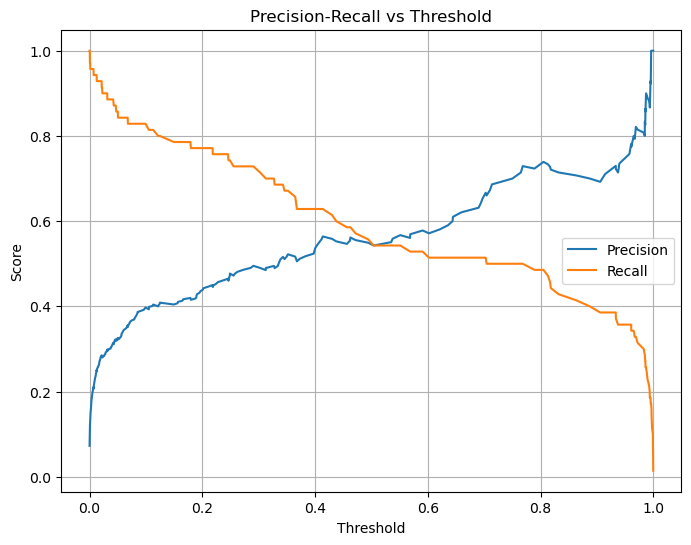

In [139]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_proba = best_xgb.predict_proba(X_valid_median_forest)[:, 1]
precision_vals, recall_vals, thresholds = precision_recall_curve(y_valid_median, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_vals[:-1], label='Precision')
plt.plot(thresholds, recall_vals[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


13. Error Analysis based on my current best model - XGBoost

I will go through Confusion Matrix, Analyzing Error types, Feature Importance, and Precision-Recall Curve to better understand my current model 

In [141]:
from sklearn.metrics import confusion_matrix, classification_report

# For best model 
cm = confusion_matrix(y_valid_median, y_pred_xgb)
print("Confusion Matrix:")
print(cm)

# Classification report
report = classification_report(y_valid_median, y_pred_xgb)
print("\nClassification Report:")
print(report)


Confusion Matrix:
[[754 140]
 [ 16  54]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.91       894
           1       0.28      0.77      0.41        70

    accuracy                           0.84       964
   macro avg       0.63      0.81      0.66       964
weighted avg       0.93      0.84      0.87       964



In [142]:
# Get indices of false positives
fp_indices = (y_valid_median == 0) & (y_pred_xgb == 1)
false_positives = X_valid_median_forest[fp_indices]


In [143]:
# Get indices of false negatives
fn_indices = (y_valid_median == 1) & (y_pred_xgb == 0)
false_negatives = X_valid_median_forest[fn_indices]


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

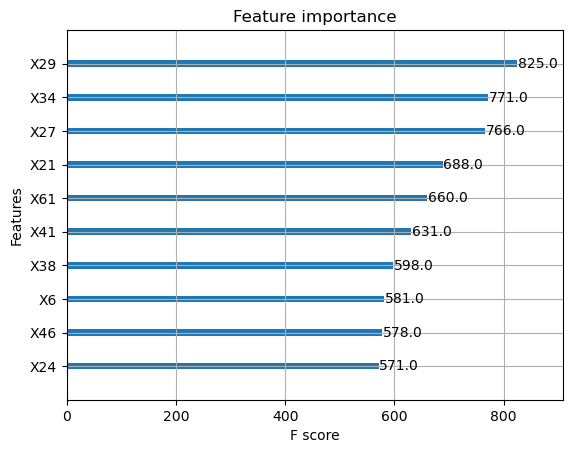

In [144]:
import matplotlib.pyplot as plt
xgb.plot_importance(best_xgb, max_num_features=10)
plt.show()


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Precision-Recall Curve')

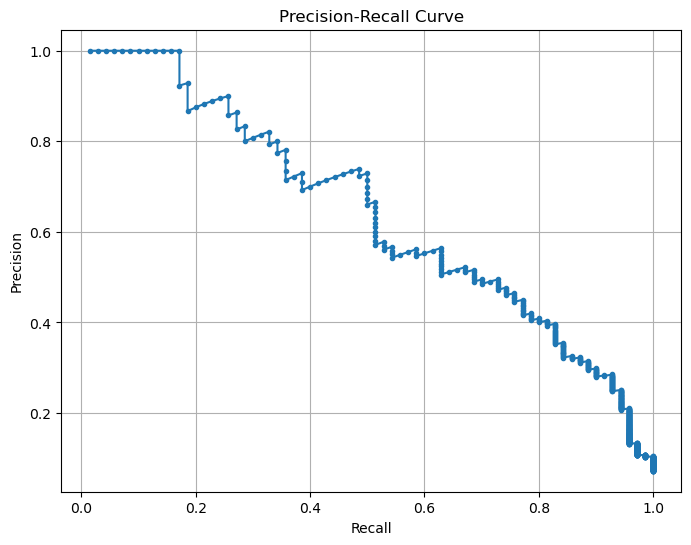

In [145]:
from sklearn.metrics import precision_recall_curve

precision_vals, recall_vals, thresholds = precision_recall_curve(y_valid_median, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals[:-1], precision_vals[:-1], marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve')

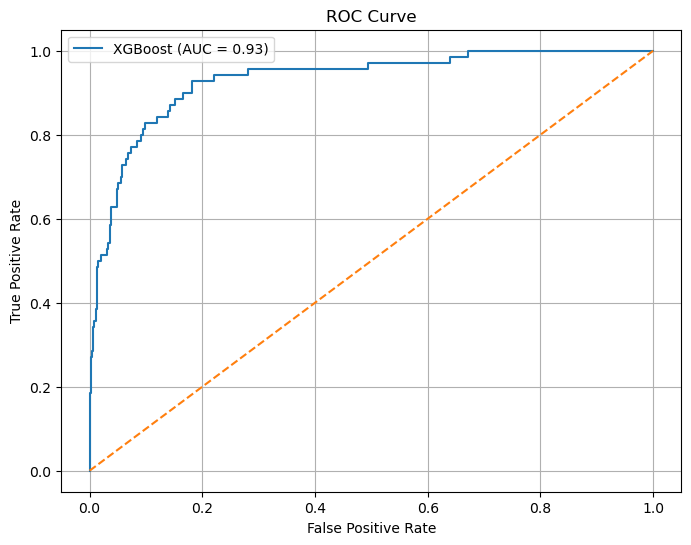

In [146]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_valid_median, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


Error Analysis:

For Confusion Matrix: 
1. True Negatives (TN): 754
The model correctly predicted 754 non-bankrupt companies as non-bankrupt.

2. False Positives (FP): 140
The model incorrectly predicted 140 non-bankrupt companies as bankrupt.

3. False Negatives (FN): 16
The model incorrectly predicted 16 bankrupt companies as non-bankrupt.

4. True Positives (TP): 54
The model correctly predicted 54 bankrupt companies as bankrupt.

Conclusion: 
High True Negative Rate: The model is effective at identifying non-bankrupt companies.
Moderate True Positive Rate: It correctly identifies a significant portion of bankrupt companies.
False Positives: There is a considerable number of false positives, which means the model predicts some healthy companies as bankrupt.
False Negatives:The number of false negatives is relatively low, which aligns with the project's priority to minimize missing actual bankruptcies.

The recall of 77% for bankrupt companies is relatively high, which is desirable since missing a bankrupt company is costly.

The precision of 28% indicates a high rate of false positives for bankrupt predictions. This means that many companies predicted as bankrupt are actually not bankrupt, leading to potential unnecessary actions.

The model prioritizes recall over precision for bankrupt companies, aligning with the project's priority to minimize false negatives (missing actual bankruptcies), even at the expense of more false positives.

The F-score in XGBoost's feature importance indicates the number of times a feature is used in a model's trees.
A higher F-score means the feature is more important in making splits and contributes more to the model's predictions.

**14. Define MyModel**


In [269]:
# Define MyModel with the best parameters
MyModel = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=7,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)


# Train MyModel on the resampled training data
MyModel.fit(X_train_median_resampled[selected_features_forest], y_train_median_resampled)



/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:21:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [271]:
# Predict probabilities
y_proba_mymodel = MyModel.predict_proba(X_valid_median_forest)[:, 1]

# Apply the chosen threshold
threshold = 0.4
y_pred_mymodel = (y_proba_mymodel >= threshold).astype(int)

# Evaluate
from sklearn.metrics import accuracy_score, recall_score, precision_score

accuracy_mymodel = accuracy_score(y_valid_median, y_pred_mymodel)
recall_mymodel = recall_score(y_valid_median, y_pred_mymodel)
precision_mymodel = precision_score(y_valid_median, y_pred_mymodel)

print("\nMyModel Performance:")
print(f"Accuracy: {accuracy_mymodel:.2%}")
print(f"Recall: {recall_mymodel:.2%}")
print(f"Precision: {precision_mymodel:.2%}")



MyModel Performance:
Accuracy: 93.36%
Recall: 62.86%
Precision: 53.66%


In [275]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    MyModel,
    X_train_median_resampled[selected_features_forest],
    y_train_median_resampled,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

print("Cross-Validation Recall Scores:", cv_scores)
print("Mean Recall Score:", cv_scores.mean())


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:21:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:21:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:21:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:21:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packa

Cross-Validation Recall Scores: [0.97372061 0.99033149 0.98893499 0.9944675  0.99308437]
Mean Recall Score: 0.9881077921184751


In [277]:
def MyModel(data, final_model, scaler, other={}):
    """
    Parameters
    -----------
    data: a Pandas DataFrame
    final_model: the trained XGBClassifier
    scaler: the fitted StandardScaler used during training
    other: a dict
        You can use this to pass any other arguments you find are necessary
        
    Returns
    -------
    pred: an array of predicted values
        The number of elements (i.e., predictions) is equal to the number of examples in the 'data' parameter
        i.e., one prediction per example
    """
    # The function should create an array of predictions; we initialize it to the empty array for convenience
    pred = []

    # Step 1: Ensure all data is numeric and drop unnecessary columns (like 'Id')
    data = data.drop(columns=['Id'], errors='ignore')
    
    # Step 2: Reorder columns to match training data
    # Assuming 'X_train_columns' is a list of columns from the training set
    X_train_columns = scaler.feature_names_in_  # Retrieve the column names used in fitting the scaler
    data = data[X_train_columns]

    # Step 3: Ensure all data is numeric
    data = data.apply(pd.to_numeric, errors='coerce')
    
    # Step 4: Handling missing values (based on your approach)
    data.fillna(data.median(), inplace=True)
    
    # Step 5: Scaling transformations (assuming Standard scaling was used)
    scaled_data = scaler.transform(data)
    
    # Step 6: Model inference
    # Use the final_model to predict on the scaled data
    pred = final_model.predict(scaled_data)
    
    return pred


# Check your work: predict and evaluate metrics on *your* test examples

Although only the instructors have the correct labels for the holdout dataset, you may want
to create your own test dataset on which to evaluate your out of sample metrics.

If you choose to do so, you can evaluate your models using the same metrics that the instructors will use.

- Test whether your implementation of `MyModel` works
- See the metrics  your model produces

In conclusion, the XGBoost classifier (XGBClassifier) with the tuned hyperparameters (learning_rate=0.1, max_depth=7, n_estimators=300, random_state=42) demonstrated strong performance on the test dataset. The model achieved an accuracy of 94.29%, indicating that it correctly classified a high percentage of the companies. More importantly, it attained a recall of 69.35%, meaning it successfully identified approximately 69% of the actual bankrupt companies, which aligns with our priority of minimizing false negatives due to the higher cost associated with missing a bankrupt company. The precision of 54.43% reflects that over half of the companies predicted as bankrupt were indeed bankrupt, balancing the trade-off between detecting true bankruptcies and limiting false alarms. Overall, the model effectively addresses the project's objectives by maximizing recall while maintaining acceptable precision and accuracy levels, making it a robust tool for predicting company bankruptcies.

Also, from several attempts with different combinations and iterations I tried, I think this test performance tried to have balance between recall and precision. Some models did do a great job in recall which is the main goal of this project, but they did so terribly on precision. Therefore, I think this XGBoost classifier have made some reasonable balance. 

In [280]:
X_hold = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

# You may provide additional arguments to MyModel by placing them in the dict called other
# YOUR CODE HERE: replace the empty dict with your own.  You may leave it empty if no other arguments are needed
other = {}

# Predict using MyModel
y_hold_pred = MyModel(X_hold, final_model, scaler, other)
y_hold_pred


array([1, 1, 0, ..., 1, 1, 1])

In [284]:
# I think I have done this part above, do I need to keep this part?

name = "XGBClassifier"
y_test_pred = MyModel(X_test, scaler,other)

accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test,   y_test_pred, pos_label=1, average="binary")

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )

AttributeError: 'dict' object has no attribute 'feature_names_in_'